# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/home/guy/datasets/'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

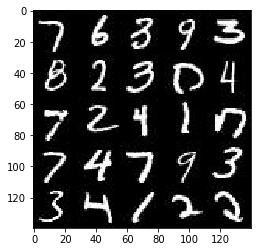

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

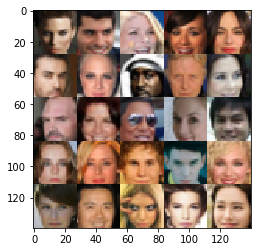

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,[None,image_height,image_width,image_channels])
    inputs_z = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/guy/anaconda3/envs/dlnd/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2   # coefficient for leaky relu
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1: input = 28x28x3
        x = tf.layers.conv2d(images,32,5,2,padding='same')
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        # now 14x14x32

        #layer 2: input = 14x14x32
        x = tf.layers.conv2d(x,64,5,2,padding='same')
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha * x, x)
        # now 7x7x64

        # layer 3: input = 7x7x64
        x_flat = tf.reshape(x,[-1,np.prod(x.shape.as_list()[1:])])

        logits = tf.layers.dense(x_flat,1)
        out = tf.sigmoid(logits)
    return logits,out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2     # coefficient for leaky relu
    # reuse of (trained) weights is needed when we want to generate images i.e. during inference
    # thus the reuse flag should be opposite to is_train
    with tf.variable_scope('generator',reuse= not is_train):
        x = tf.layers.dense(z,7*7*64)
        x = tf.reshape(x,(-1,7,7,64))
        x = tf.layers.batch_normalization(x,training = is_train)
        x = tf.maximum(alpha*x,x)
        # now the tensor is [N,7,7,64]

        # Layer 2:
        x = tf.layers.conv2d_transpose(x,32,5,2,padding='same')
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)
        # now the tensor is [N,14,14,32]

        # Layer 3: the last layer to bring it to image size of 28x28
        logits = tf.layers.conv2d_transpose(x,out_channel_dim,5,2,padding='same')

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    # define a generator network
    input_fake = generator(input_z,out_channel_dim,is_train=True)

    # define a discriminator that gets fake
    d_out_fake,d_logits_fake = discriminator(input_fake)

    # define a discriminator that gets real
    d_out_real,d_logits_real = discriminator(input_real,reuse=True)

    # define loss_d_real - the loss for real images - should be compared to ones
    # loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real)))
    loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real)*(1.0-smooth)))
    # define loss_d_fake - the loss for the fake images - should be compared to zeros
    loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))

    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_out_fake)))
    # define loss_g as the opposite of loss_d_fake. i.e. should be compared to ones
    loss_d=loss_d_real + loss_d_fake

    return loss_d, loss_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr = model_inputs(data_shape[2],data_shape[1],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    # train the model
    saver = tf.train.Saver()
    losses=[]
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))

                # Run optimizers
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})

                if steps % 10 ==0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 ==0:
                    show_generator_output(sess,72,input_z,data_shape[3],data_image_mode)

        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.4575
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.6429


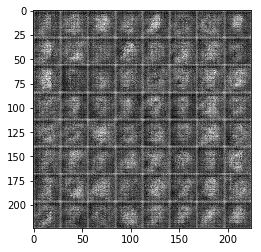

Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.6474
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.6638


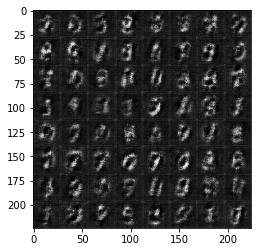

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.6645


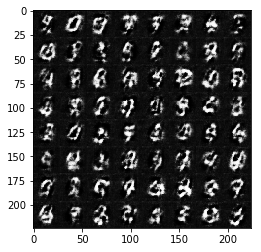

Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.6383


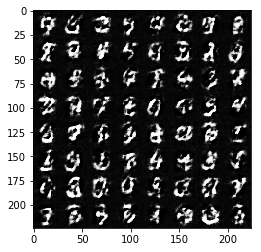

Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.6359


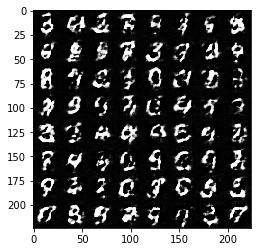

Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6611
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6570


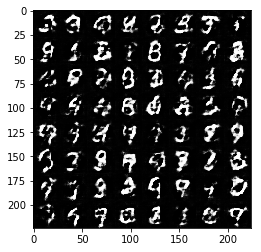

Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.6253
Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.6309


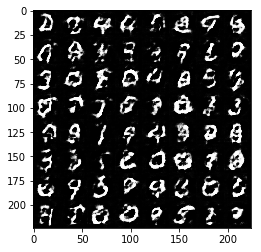

Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.6756
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.6849


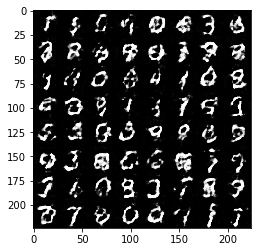

Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.6310


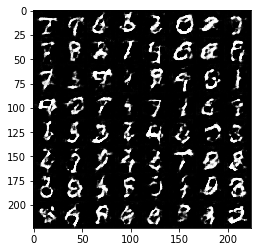

Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.6146


In [12]:
batch_size = 128
z_dim = 20
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6824


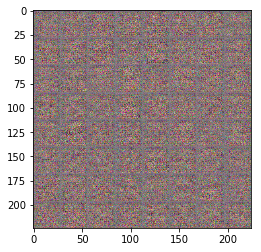

Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.6897


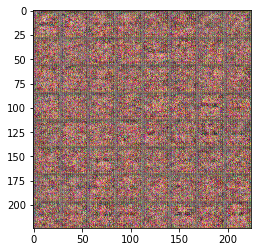

Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6919


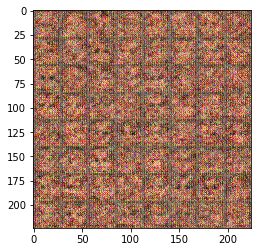

Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.6918


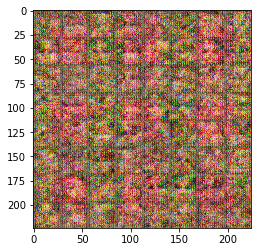

Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6920


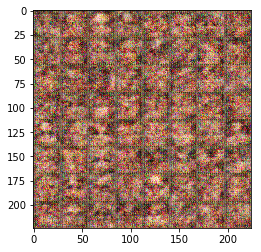

Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6923


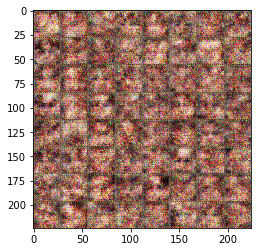

Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.6918


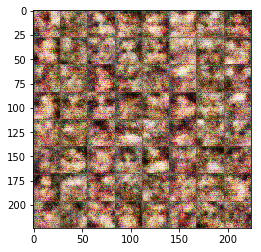

Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.6923


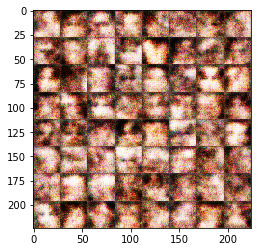

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.6524


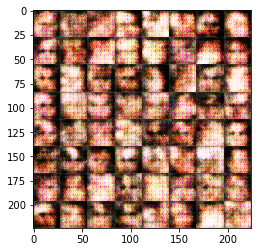

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6707


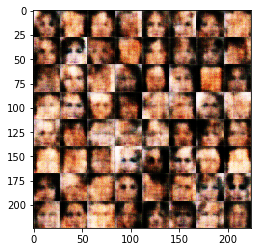

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5724


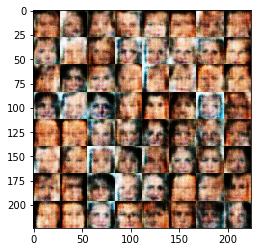

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6109


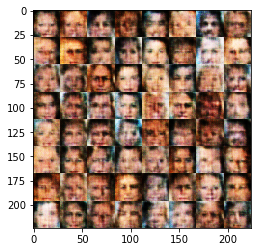

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6898


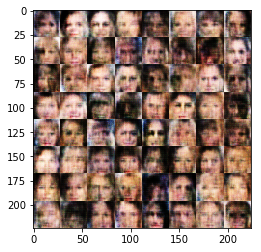

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6926


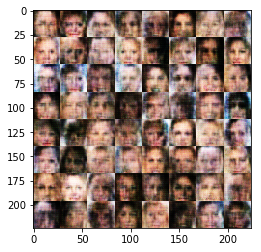

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6905


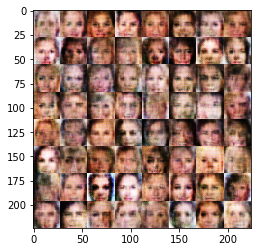

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6502


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.